# Reinforcement Learning - Monte Carlo
In this assignment you will use Monte Carlo methods to estimate a value function of a policy.

In [200]:
# This cell imports %%execwritefile command (executes cell and writes it into file).
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [201]:
%%execwritefile mc_autograde.py
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting mc_autograde.py


In [202]:
import matplotlib.pyplot as plt
import sys

%matplotlib inline

## 1. Monte Carlo Prediction

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [203]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we no longer have transition probabilities and we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [204]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

Init signature: gym.Env()
Docstring:     
The main OpenAI Gym class. It encapsulates an environment with
arbitrary behind-the-scenes dynamics. An environment can be
partially or fully observed.

The main API methods that users of this class need to know are:

    step
    reset
    render
    close
    seed

And set the following attributes:

    action_space: The Space object corresponding to valid actions
    observation_space: The Space object corresponding to valid observations
    reward_range: A tuple corresponding to the min and max possible rewards

Note: a default reward range set to [-inf,+inf] already exists. Set it if you want a narrower range.

The methods are accessed publicly as "step", "reset", etc.. The
non-underscored versions are wrapper methods to which we may add
functionality over time.
File:           c:\users\lisan\anaconda3\envs\rlcourse\lib\site-packages\gym\core.py
Type:           type
Subclasses:     GoalEnv, Wrapper, BlackjackEnv


In [205]:
# We can also look at the documentation/implementation of a method
?env.step

Signature: env.step(action)
Docstring:
Run one timestep of the environment's dynamics. When end of
episode is reached, you are responsible for calling `reset()`
to reset this environment's state.

Accepts an action and returns a tuple (observation, reward, done, info).

Args:
    action (object): an action provided by the environment

Returns:
    observation (object): agent's observation of the current environment
    reward (float) : amount of reward returned after previous action
    done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
    info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
File:      c:\users\lisan\onedrive\documenten\uni\master ai uva\rl\uva-rl\assignment2\blackjack.py
Type:      method


In [206]:
??BlackjackEnv

Init signature: BlackjackEnv(natural=False)
Source:        
class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is

In [207]:
??env.action_space

Type:        Discrete
String form: Discrete(2)
File:        c:\users\lisan\anaconda3\envs\rlcourse\lib\site-packages\gym\spaces\discrete.py
Source:     
class Discrete(gym.Space):
    """
    {0,1,...,n-1}

    Example usage:
    self.observation_space = spaces.Discrete(2)
    """
    def __init__(self, n):
        self.n = n
        gym.Space.__init__(self, (), np.int64)

    def sample(self):
        return gym.spaces.np_random.randint(self.n)

    def contains(self, x):
        if isinstance(x, int):
            as_int = x
        elif isinstance(x, (np.generic, np.ndarray)) and (x.dtype.kind in np.typecodes['AllInteger'] and x.shape == ()):
            as_int = int(x)
        else:
            return False
        return as_int >= 0 and as_int < self.n

    def __repr__(self):
        return "Discrete(%d)" % self.n

    def __eq__(self, other):
        return self.n == other.n


A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or, a function or a class with a function, where we use the last option. Moreover, it is often useful (as you will see later) to implement a function that returns  the probability $\pi(a|s)$ for the state action pair (the probability that this policy would perform certain action in given state). We group these two functions in a policy class. To get started, let's implement this simple policy for BlackJack.

In [208]:
%%execwritefile -a mc_autograde.py

class SimpleBlackjackPolicy(object):
    """
    A simple BlackJack policy that sticks with less than 20 points and hits otherwise.
    """
    def get_probs(self, states, actions):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains a probability
        of perfoming action in given state for every corresponding state action pair.

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """
        # YOUR CODE HERE
        probs = np.zeros(len(actions))
        for s in enumerate(states):            
            for a  in actions: 
                # If >= 20, stick
                if a == 0 and s[0] >= 20:
                    probs[a] = 1

                # If < 20, hit
                elif a == 1 and s[0] < 20:
                    probs[a] = 1

                # Otherwise, 0
                else:
                    probs[a] = 0

        return np.array(probs)

    def sample_action(self, state):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            state: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        if state[0] >= 20:
            return 0
        else:
            return 1
        return action


Appending to mc_autograde.py


In [209]:
# Let's check if it makes sense
env = BlackjackEnv()
s = env.reset()
policy = SimpleBlackjackPolicy()
print("State: {}\nSampled Action: {}\nProbabilities [stick, hit]: {}".format(s, policy.sample_action(s), policy.get_probs([s,s],[0,1])))

State: (18, 10, False)
Sampled Action: 1
Probabilities [stick, hit]: [0. 1.]


Since there are multiple algorithms which require data from single episode (or multiple episodes) it is useful to write a routine that will sample a single episode. This will save us some time later. Implement a *sample_episode* function which uses environment and policy to sample a single episode.

In [210]:
%%execwritefile -a mc_autograde.py

def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length.
        Hint: Do not include the state after the termination in the list of states.
    """
    states = []
    actions = []
    rewards = []
    dones = []

    # YOUR CODE HERE
    state = env.reset()
    done = False

    while not done:
        action = policy.sample_action(state)
        next_state, reward, done, _ = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        state = next_state
        
    return states, actions, rewards, dones

Appending to mc_autograde.py


In [211]:
# Let's sample some episodes
env = BlackjackEnv()
policy = SimpleBlackjackPolicy()
for episode in range(3):
    trajectory_data = sample_episode(env, policy)
    print("Episode {}:\nStates {}\nActions {}\nRewards {}\nDones {}\n".format(episode,*trajectory_data))

Episode 0:
States [(13, 3, False)]
Actions [1]
Rewards [-1]
Dones [True]

Episode 1:
States [(16, 4, False)]
Actions [1]
Rewards [-1]
Dones [True]

Episode 2:
States [(12, 5, False), (13, 5, False), (14, 5, False)]
Actions [1, 1, 1]
Rewards [0, 0, -1]
Dones [False, False, True]



Now implement the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [212]:
%%execwritefile -a mc_autograde.py

def mc_prediction(policy, env, num_episodes, discount_factor=1.0, sampling_function=sample_episode):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.

    Args:
        policy: A policy which allows us to sample actions with its sample_action method.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.

    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of current V and count of returns for each state
    # to calculate an update.
    V = defaultdict(float)
    returns_count = defaultdict(float)

    # YOUR CODE HERE
    for i in tqdm(range(num_episodes)):
        states, actions, rewards, dones = sample_episode(env, policy)
        G = 0
        for t in range(len(states)-1, -1, -1):
            G = discount_factor*G + rewards[t]
            if states[t] not in states[:t]:
                returns_count[states[t]] += 1
                V[states[t]] += (G - V[states[t]]) / returns_count[states[t]]

    return V

Appending to mc_autograde.py


In [213]:
V_10k = mc_prediction(SimpleBlackjackPolicy(), env, num_episodes=10000)
print(V_10k)

100%|██████████| 10000/10000 [00:00<00:00, 22530.12it/s]

defaultdict(<class 'float'>, {(19, 10, False): -0.7078384798099757, (16, 10, False): -0.6635514018691587, (14, 10, False): -0.6302083333333335, (12, 1, False): -0.6296296296296294, (14, 5, False): -0.5887850467289716, (21, 10, False): 0.8678571428571422, (15, 10, False): -0.6153846153846158, (16, 5, False): -0.6907216494845358, (18, 3, False): -0.8490566037735852, (20, 2, False): 0.5889570552147241, (20, 8, False): 0.7785714285714286, (19, 9, False): -0.8490566037735847, (18, 8, False): -0.6842105263157894, (20, 4, False): 0.6909090909090909, (15, 4, False): -0.5806451612903226, (21, 5, True): 0.9130434782608696, (17, 10, False): -0.6932367149758458, (12, 9, False): -0.5476190476190477, (16, 9, False): -0.6699999999999998, (20, 1, False): 0.0816326530612245, (13, 7, False): -0.6000000000000001, (21, 1, False): 0.6705882352941178, (17, 1, False): -0.7314814814814815, (18, 10, False): -0.733031674208145, (16, 6, False): -0.717171717171717, (20, 7, False): 0.785714285714286, (15, 6, False

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [214]:
%%time
# Let's run your code one time
V_500k = mc_prediction(SimpleBlackjackPolicy(), env, num_episodes=500000)

100%|██████████| 500000/500000 [00:21<00:00, 22824.96it/s]

Wall time: 21.9 s


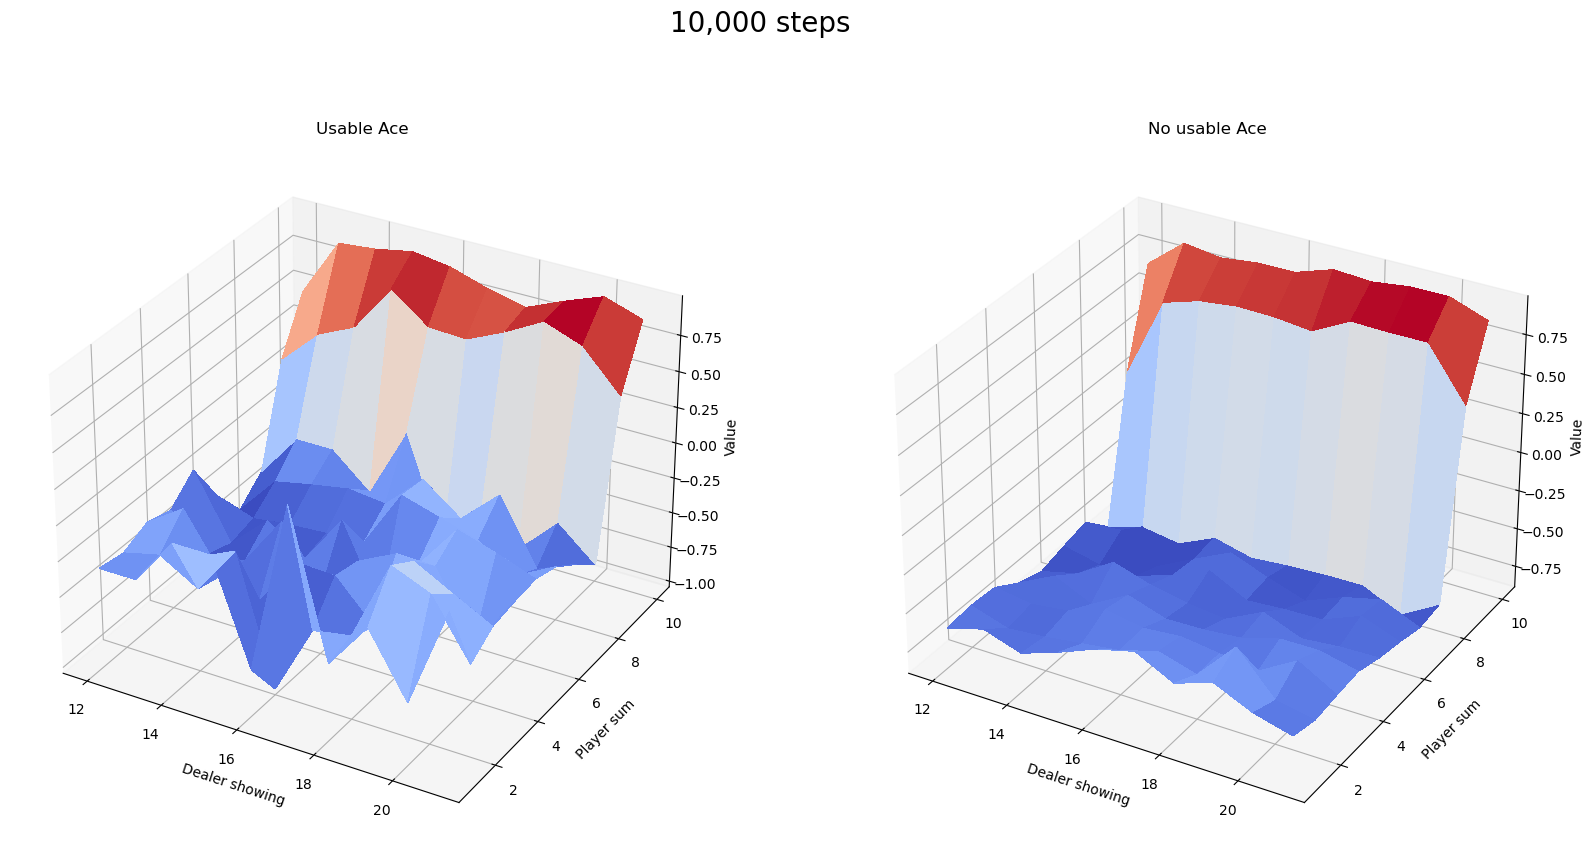

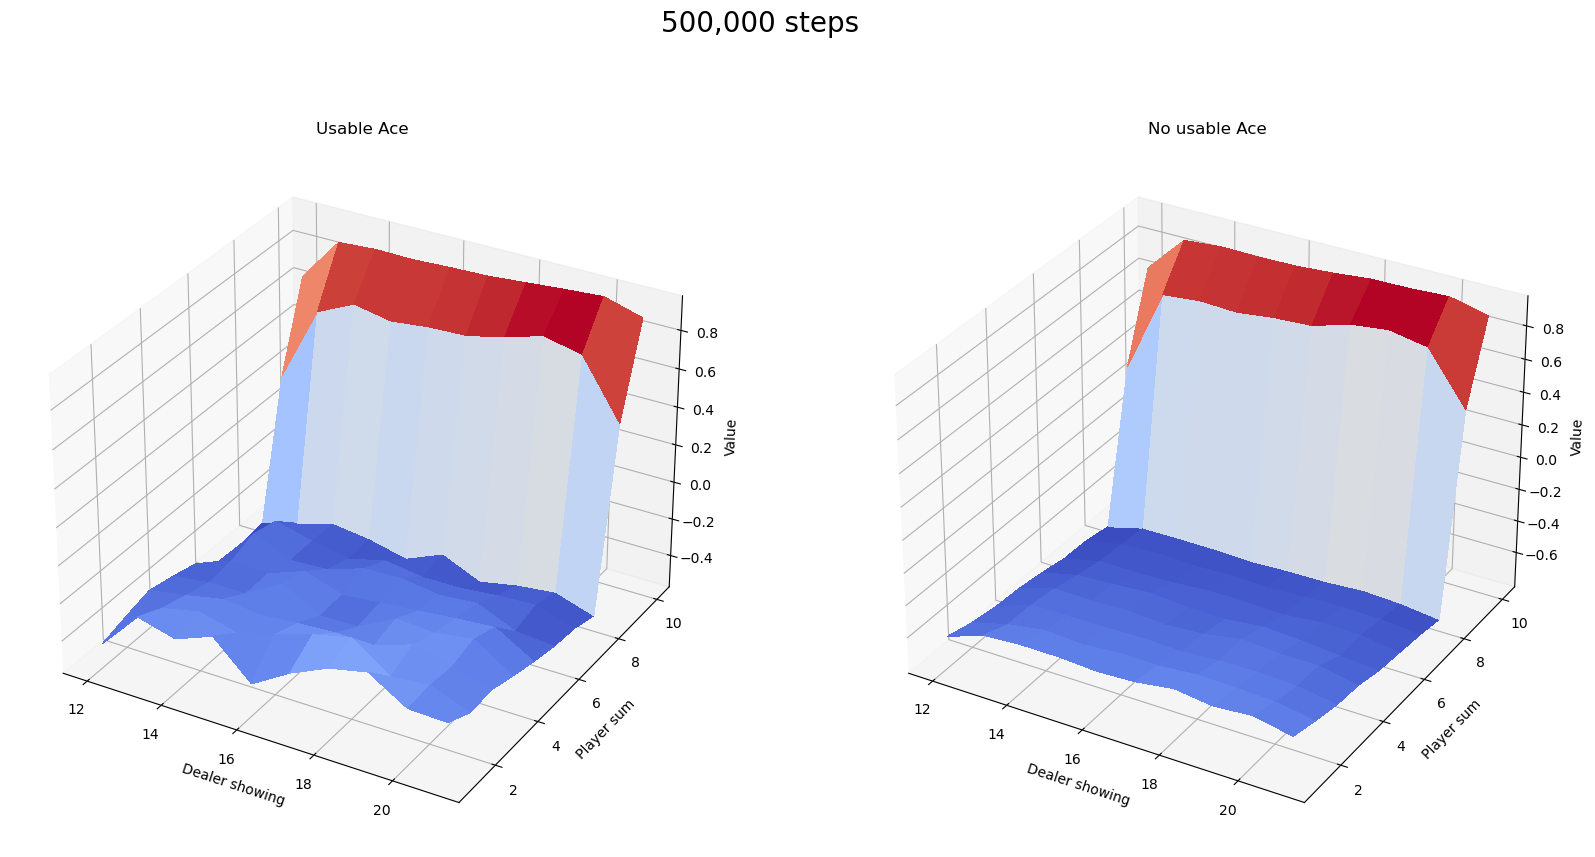

In [215]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

def plot_blackjack_value_function(V, title="Value Function"):

    # YOUR CODE HERE
    
    # Initialize value functions with and without usable ace
    V_ace = np.zeros((10, 10))
    V_no_ace = np.zeros((10, 10))
    
    # Assign values to the value functions
    for key, value in V.items():
        if key[2]:
            V_ace[key[0]-12, key[1]-1] = value
        else:
            V_no_ace[key[0]-12, key[1]-1] = value

    # Create a figure
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle(title, fontsize=20)
    
    # Subplot for Usable Ace
    ax = fig.add_subplot(121, projection='3d')
    x = np.arange(12, 22)
    y = np.arange(1, 11)
    x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, V_ace, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_ylabel('Player sum')
    ax.set_xlabel('Dealer showing')
    ax.set_zlabel('Value')
    ax.set_title('Usable Ace')
    
    # Subplot for No Usable Ace
    ax = fig.add_subplot(122, projection='3d')
    x = np.arange(12, 22)
    y = np.arange(1, 11)
    x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, V_no_ace, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_ylabel('Player sum')
    ax.set_xlabel('Dealer showing')
    ax.set_zlabel('Value')
    ax.set_title('No usable Ace')
    
    plt.show()
   

plot_blackjack_value_function(V_10k, "10,000 steps")
plot_blackjack_value_function(V_500k, "500,000 steps")

## 2. Off-policy Monte Carlo prediction
In real world, it is often beneficial to learn from the experience of others in addition to your own. For example, you can probably infer that running off the cliff with a car is a bad idea if you consider what "return" people who have tried it received.

Similarly, we can benefit from the experience of other agents in reinforcement learning. In this exercise we will use off-policy monte carlo to estimate the value function of our target policy using the experience from a different behavior policy. Our target policy will be the simple policy as defined above (stick if we have *20* or *21* points) and we will use random policy as a behavior policy. As a first step, implement a random BlackJack policy.

In [216]:
%%execwritefile -a mc_autograde.py

class RandomBlackjackPolicy(object):
    """
    A random BlackJack policy.
    """
    def get_probs(self, states, actions):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains
        a probability of perfoming action in given state for every corresponding state action pair.

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """

        # YOUR CODE HERE
        probs = np.full(len(actions), 1/len(actions))

        return np.array(probs)

    def sample_action(self, state):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            state: current state

        Returns:
            An action (int).
        """

        # YOUR CODE HERE
        action = np.random.choice([0, 1])

        return action


Appending to mc_autograde.py


In [217]:
# Let's check if it makes sense
env = BlackjackEnv()
s = env.reset()
policy = RandomBlackjackPolicy()
print("State: {}\nSampled Action: {}\nProbabilities [stick, hit]: {}".format(s, policy.sample_action(s), policy.get_probs([s,s],[0,1])))

State: (12, 10, False)
Sampled Action: 1
Probabilities [stick, hit]: [0.5 0.5]


Now implement the MC prediction algorithm with ordinary importance sampling

Hint: you can use for i in tqdm(range(num_episodes)) to show a progress bar.

In [218]:
%%execwritefile -a mc_autograde.py

def mc_importance_sampling(behavior_policy, target_policy, env, num_episodes, discount_factor=1.0,
                           sampling_function=sample_episode):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.

    Args:
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.

    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of current V and count of returns for each state
    # to calculate an update.
    V = defaultdict(float)
    returns_count = defaultdict(float)

    # YOUR CODE HERE
    for i in tqdm(range(num_episodes)):
        states, actions, rewards, dones = sample_episode(env, behavior_policy)
        G = 0
        W = 1
        for t in range(len(states)-1, -1, -1):
            G = discount_factor*G + rewards[t]
            returns_count[states[t]] += W
            V[states[t]] += (W / returns_count[states[t]]) * (G - V[states[t]])
            # if actions[t] != target_policy.sample_action(states[t]):
            #     break
            target_probs = target_policy.get_probs([states[t]], [0,1])
            behavior_probs = behavior_policy.get_probs([states[t]], [0,1])
            # print(target_probs, behavior_probs, actions[t])
            W *= target_probs[actions[t]] / behavior_probs[actions[t]]    
    return V

Appending to mc_autograde.py


In [219]:
%%time
# Let's run your code one time
V_10k = mc_importance_sampling(RandomBlackjackPolicy(), SimpleBlackjackPolicy(), env, num_episodes=10000)
print(V_10k)

100%|██████████| 10000/10000 [00:00<00:00, 17263.54it/s]

defaultdict(<class 'float'>, {(19, 6, False): -0.35714285714285726, (13, 5, False): -0.5121951219512195, (15, 4, False): -0.4615384615384615, (12, 2, False): -0.6179775280898876, (16, 6, False): -0.6170212765957442, (18, 10, False): -0.703264094955489, (14, 10, False): nan, (21, 3, True): -0.17777777777777778, (16, 9, False): -0.806451612903226, (14, 8, False): -0.7999999999999999, (15, 2, False): -0.7866666666666667, (19, 7, False): -0.01282051282051285, (13, 7, False): -0.717948717948718, (18, 7, True): -0.375, (17, 10, False): -0.8098360655737704, (19, 3, False): -0.353846153846154, (20, 5, False): -0.14035087719298245, (16, 10, False): -0.7791411042944785, (15, 3, False): -0.7209302325581395, (21, 4, False): -0.06557377049180324, (21, 4, True): nan, (15, 9, False): -0.7777777777777778, (15, 10, False): -0.7910447761194026, (12, 5, False): -0.5157894736842105, (20, 10, False): -0.30468750000000017, (19, 5, False): -0.4204545454545454, (17, 2, False): -0.5696202531645572, (20, 1, Fal

In [220]:
V_500k = mc_importance_sampling(RandomBlackjackPolicy(), SimpleBlackjackPolicy(), env, num_episodes=500000)

100%|██████████| 500000/500000 [00:27<00:00, 18466.55it/s]


Let's plot the V function.

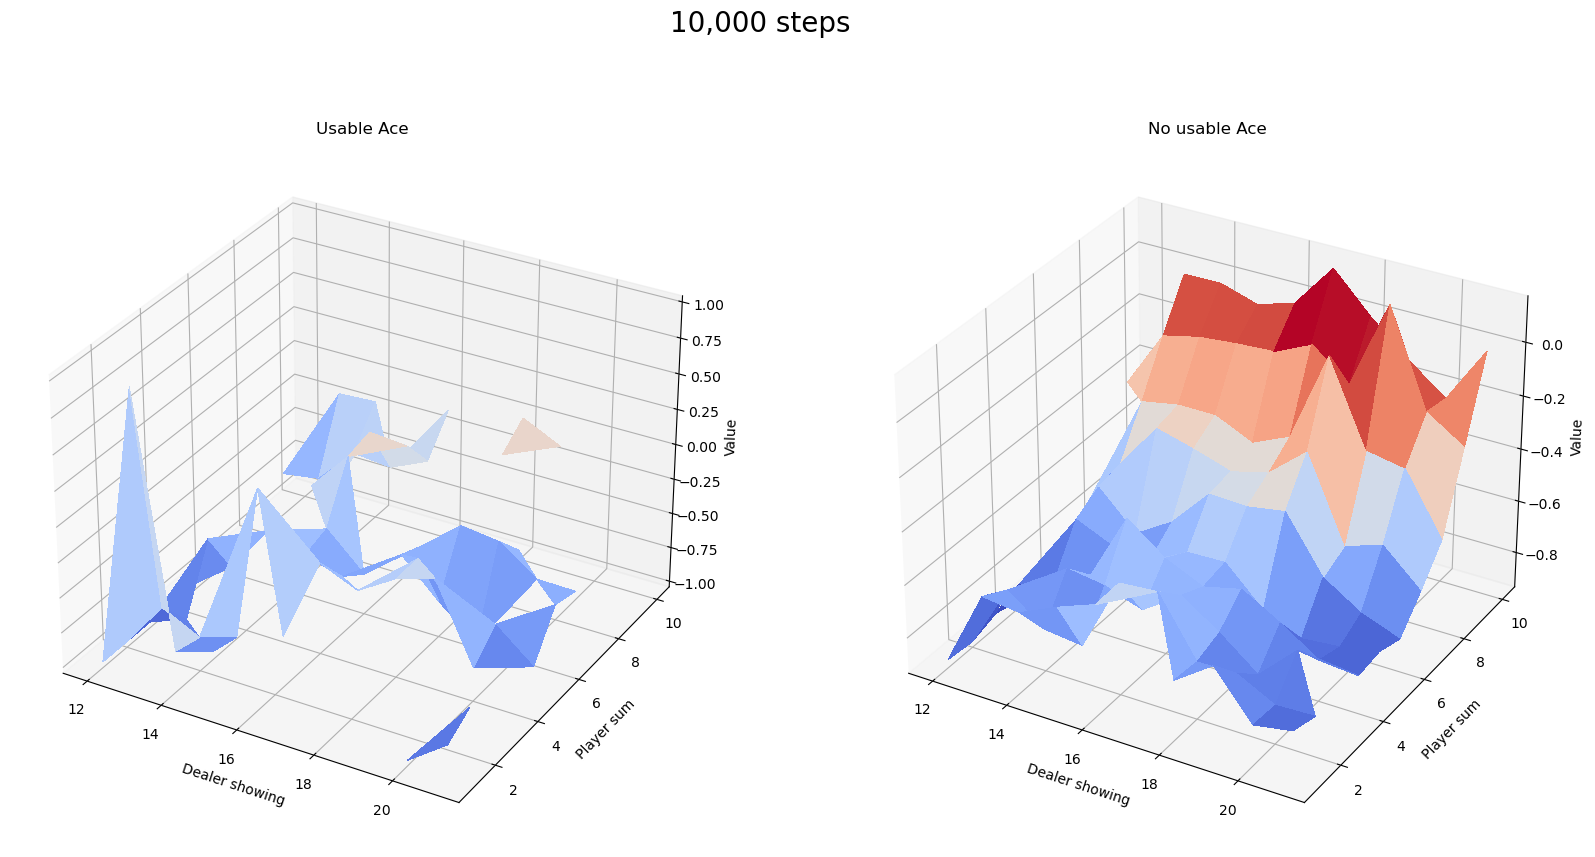

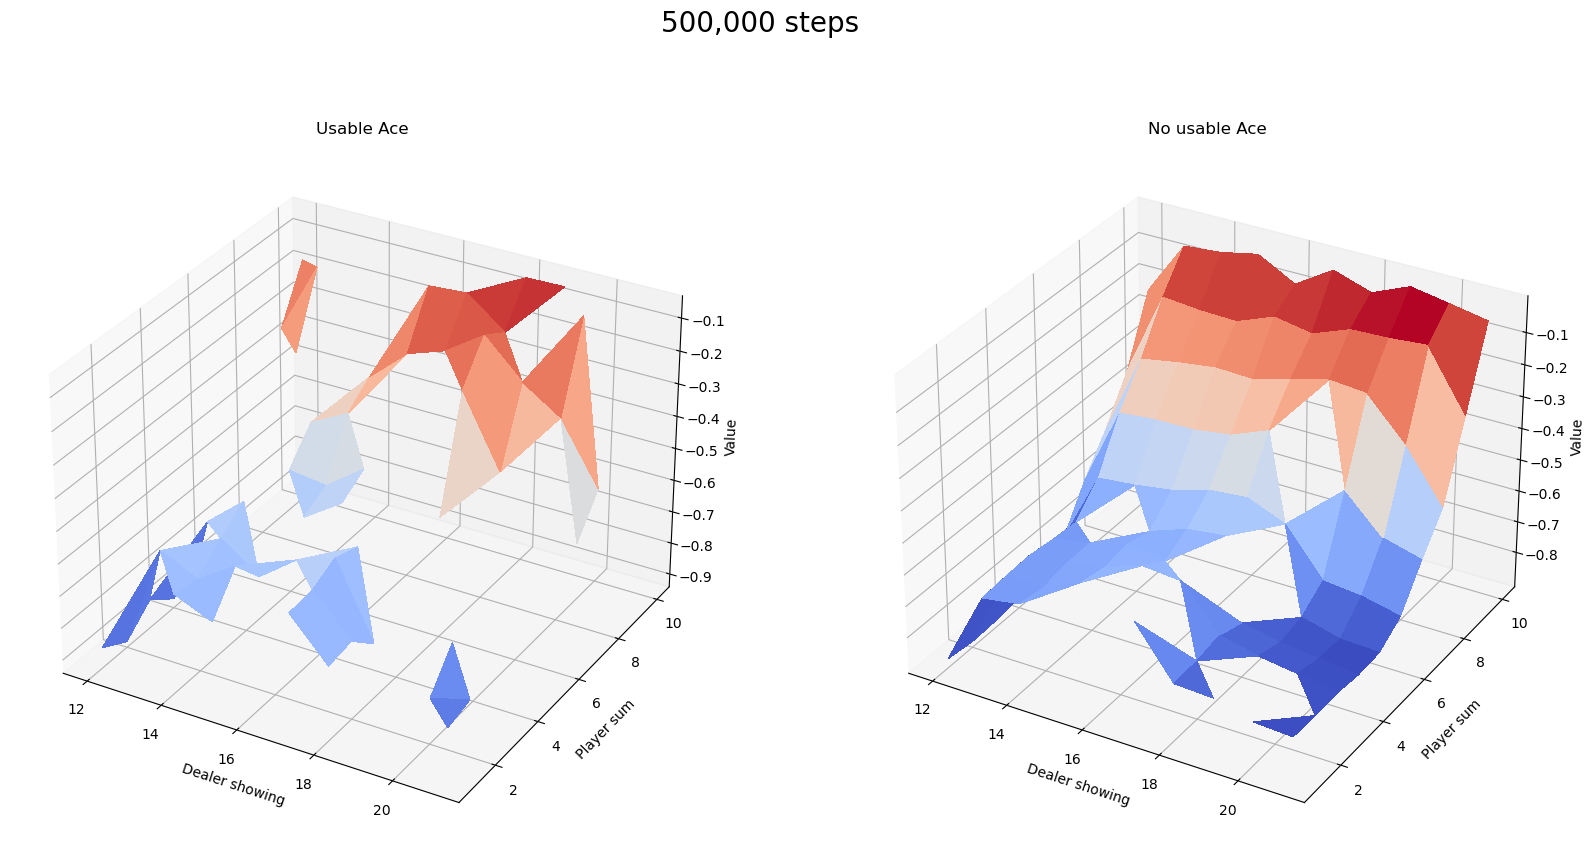

In [221]:
plot_blackjack_value_function(V_10k, "10,000 steps")
plot_blackjack_value_function(V_500k, "500,000 steps")